In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot as qq
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("Marketing_Campaign_Effectiveness.csv")
df.head()

MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1     Medium           1           4          3     1   
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0             33.73  
1             35.67  
2             29.03  
3             39.25  
4             27.81

### Test Base Model (Random Forest) on Raw Data

In [3]:
market_ = {i:j for j, i in enumerate(np.unique(df.MarketSize))}
market_

{'Large': 0, 'Medium': 1, 'Small': 2}

In [4]:
res = [market_[i] for i in df.MarketSize]
df['MarketSize'] = res

In [5]:
X_ = df.drop(['SalesInThousands'], axis = 1).copy()
y_ = df.SalesInThousands.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 

#Create base random forest model
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X=x_train,y=y_train)

pred = regr.predict(x_test)
base_mae = mean_absolute_error(y_test, pred)
print("Base Model Mae %.3f" % base_mae)

Base Model Mae 6.190


C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## EDA

C:\Users\edalr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


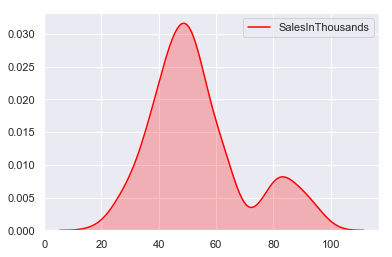

In [6]:
sns.set(color_codes=True)
ax = sns.kdeplot(df.SalesInThousands, shade = True, color = 'red')
plt.show()

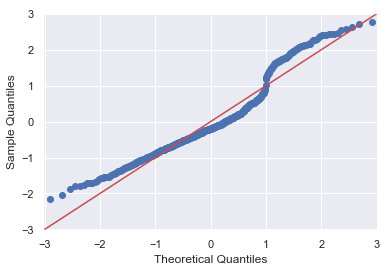

In [7]:
fig = qq(df.SalesInThousands, fit=True, line='45')
plt.show()

In [8]:
df.MarketSize.value_counts()

1    320
0    168
2     60
Name: MarketSize, dtype: int64

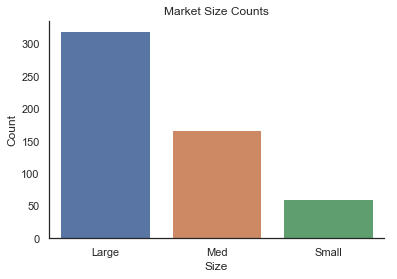

In [9]:
sns.set(style="white")
ax = sns.barplot(x=["Large", "Med", "Small"], y=df.MarketSize.value_counts())
ax.set_title("Market Size Counts")
ax.set(ylabel = "Count", xlabel="Size")
sns.despine()
plt.show()

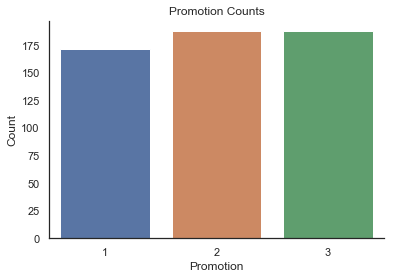

In [10]:
sns.set(style="white")
ax = sns.barplot(x=df.Promotion.value_counts().index, y=df.Promotion.value_counts())
ax.set_title("Promotion Counts")
ax.set(ylabel = "Count", xlabel="Promotion")
sns.despine()
plt.show()

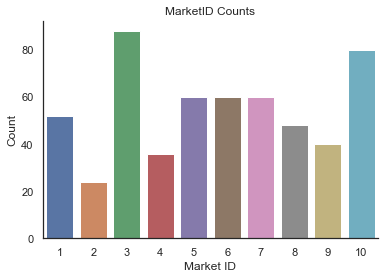

In [11]:
sns.set(style="white")
ax = sns.barplot(x=df.MarketID.value_counts().index, y=df.MarketID.value_counts())
ax.set_title("MarketID Counts")
ax.set(ylabel = "Count", xlabel="Market ID")
sns.despine()
plt.show()

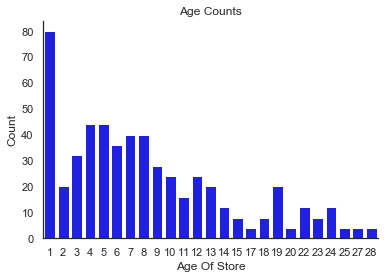

In [12]:
sns.set(style="white")
ax = sns.barplot(x=df.AgeOfStore.value_counts().index, y=df.AgeOfStore.value_counts(), color="blue")
ax.set_title("Age Counts")
ax.set(ylabel = "Count", xlabel="Age Of Store")
sns.despine()
plt.show()

## Feature Engineering

#### Percent Changes in Sales from Week to Week 

In [13]:
no_locs = np.unique(df.LocationID)
pct_change = [list(df[df.LocationID == i].SalesInThousands.pct_change()) for i in no_locs]
pct_ch = [j for i in pct_change for j in i]

In [14]:
df['pct_change'] = pct_ch

In [15]:
df.fillna(0, inplace = True)
df.head()

MarketID  MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1           1           1           4          3     1   
1         1           1           1           4          3     2   
2         1           1           1           4          3     3   
3         1           1           1           4          3     4   
4         1           1           2           5          2     1   

   SalesInThousands  pct_change  
0             33.73    0.000000  
1             35.67    0.057516  
2             29.03   -0.186151  
3             39.25    0.352050  
4             27.81    0.000000

## Solution to Bimodal Distribution

We can split the data into 2 groups and create models specifically for stores with Sales greater than 73

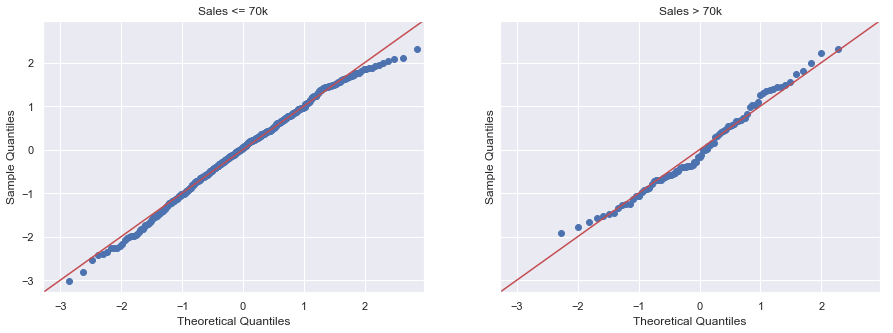

In [16]:
sales_l70 = df[df.SalesInThousands <= 73]
sales_g70 = df[df.SalesInThousands > 73]


sns.set(color_codes=True)
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))
qq(sales_l70.SalesInThousands, fit=True, line='45', ax=ax[0])
qq(sales_g70.SalesInThousands, fit=True, line='45', ax=ax[1])
ax[0].set_title("Sales <= 70k")
ax[1].set_title("Sales > 70k")
plt.show()

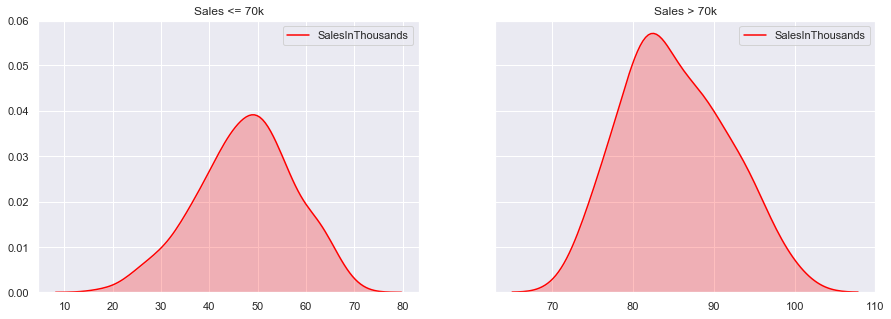

In [17]:
sns.set(color_codes=True)
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))
sns.kdeplot(sales_l70.SalesInThousands, shade = True, color = 'red', ax=ax[0])
sns.kdeplot(sales_g70.SalesInThousands, shade = True, color = 'red', ax=ax[1])
ax[0].set_title("Sales <= 70k")
ax[1].set_title("Sales > 70k")
plt.show()


## Retest Random Forest On Both Sets of Data

#### On Sales Less than 70 Thousand

In [18]:
X_ = sales_l70.drop(['SalesInThousands', 'pct_change'], axis = 1).copy()
y_ = sales_l70.SalesInThousands.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 

#Create base random forest model
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X=x_train,y=y_train)

pred = regr.predict(x_test)
l70_mae = mean_absolute_error(y_test, pred)
print("L70 Mae %.3f" % l70_mae)

L70 Mae 6.187


C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### On Sales Greater Than 70 Thousand

In [19]:
X_ = sales_g70.drop(['SalesInThousands', 'pct_change'], axis = 1).copy()
y_ = sales_g70.SalesInThousands.copy()

#Split the data into test and training sets
x_train2, x_test2, y_train2, y_test2 = train_test_split(X_, y_, test_size=0.2, random_state=42) 

#Create base random forest model
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X=x_train2,y=y_train2)

pred = regr.predict(x_test2)
g70_mae = mean_absolute_error(y_test2, pred)
print("G70 Mae %.3f" % g70_mae)

G70 Mae 3.528


C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## 1. Multiple Linear Regression Model On Both Sets of Sales Data

In [20]:
cols = list(df.drop(['SalesInThousands', 'AgeOfStore', 'pct_change', 'LocationID'], axis=1).columns)
cols

['MarketID', 'MarketSize', 'Promotion', 'week']

#### One Hot Encode Relevant Categorical Variables

In [21]:
l70_df = pd.get_dummies(data=sales_l70, columns = cols)
g70_df = pd.get_dummies(data=sales_g70, columns = cols)

In [22]:
l70_df.head()

LocationID  AgeOfStore  SalesInThousands  pct_change  MarketID_1  \
0           1           4             33.73    0.000000           1   
1           1           4             35.67    0.057516           1   
2           1           4             29.03   -0.186151           1   
3           1           4             39.25    0.352050           1   
4           2           5             27.81    0.000000           1   

   MarketID_2  MarketID_3  MarketID_4  MarketID_5  MarketID_6   ...    \
0           0           0           0           0           0   ...     
1           0           0           0           0           0   ...     
2           0           0           0           0           0   ...     
3           0           0           0           0           0   ...     
4           0           0           0           0           0   ...     

   MarketSize_0  MarketSize_1  MarketSize_2  Promotion_1  Promotion_2  \
0             0             1             0            0            0   
1             0             1             0            0            0   
2             0             1             0            0            0   
3             0             1             0            0            0   
4             0             1             0            0            1   

   Promotion_3  week_1  week_2  week_3  week_4  
0            1       1       0       0       0  
1            1       0       1       0       0  
2            1       0       0       1       0  
3            1       0       0       0       1  
4            0       1       0       0       0  

[5 rows x 24 columns]

In [23]:
l70_df.shape

(461, 24)

In [24]:
g70_df.shape

(87, 13)

In [25]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

#### Split the data to handle bimodal distribution

In [26]:
X_ = l70_df.drop(['SalesInThousands'], axis = 1).copy()
y_ = l70_df.SalesInThousands.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 

lm = LinearRegression()
model = lm.fit(x_train, y_train)

In [27]:
pred = lm.predict(x_test)

In [28]:
lm1_mae = mean_absolute_error(y_test, pred)
print("l70 lm Mae %.3f" % lm1_mae)

l70 lm Mae 2.979


In [29]:
g70_df.head(3)

LocationID  AgeOfStore  SalesInThousands  pct_change  MarketID_3  \
76         201           4             86.14     0.00000           1   
77         201           4             82.56    -0.04156           1   
78         201           4             79.36    -0.03876           1   

    MarketSize_0  Promotion_1  Promotion_2  Promotion_3  week_1  week_2  \
76             1            0            0            1       1       0   
77             1            0            0            1       0       1   
78             1            0            0            1       0       0   

    week_3  week_4  
76       0       0  
77       0       0  
78       1       0

In [30]:
X_ = g70_df.drop(['SalesInThousands'], axis = 1).copy()
y_ = g70_df.SalesInThousands.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 

lm = LinearRegression()
model = lm.fit(x_train, y_train)
pred = lm.predict(x_test)

lm2_mae = mean_absolute_error(y_test, pred)
print("G70 lm Mae %.3f" % lm2_mae)

G70 lm Mae 2.733


## Classification Models

In [31]:
df.head()

MarketID  MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1           1           1           4          3     1   
1         1           1           1           4          3     2   
2         1           1           1           4          3     3   
3         1           1           1           4          3     4   
4         1           1           2           5          2     1   

   SalesInThousands  pct_change  
0             33.73    0.000000  
1             35.67    0.057516  
2             29.03   -0.186151  
3             39.25    0.352050  
4             27.81    0.000000

In [32]:
sales70 = {True:1, False:0}
sales70_flag = [sales70[i > 70] for i in df.SalesInThousands]
df['sales70_flag'] = sales70_flag

In [33]:
df.head()

MarketID  MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1           1           1           4          3     1   
1         1           1           1           4          3     2   
2         1           1           1           4          3     3   
3         1           1           1           4          3     4   
4         1           1           2           5          2     1   

   SalesInThousands  pct_change  sales70_flag  
0             33.73    0.000000             0  
1             35.67    0.057516             0  
2             29.03   -0.186151             0  
3             39.25    0.352050             0  
4             27.81    0.000000             0

In [34]:
cols

['MarketID', 'MarketSize', 'Promotion', 'week']

In [35]:
log_df = pd.get_dummies(data=df, columns = cols)
log_df.head()

LocationID  AgeOfStore  SalesInThousands  pct_change  sales70_flag  \
0           1           4             33.73    0.000000             0   
1           1           4             35.67    0.057516             0   
2           1           4             29.03   -0.186151             0   
3           1           4             39.25    0.352050             0   
4           2           5             27.81    0.000000             0   

   MarketID_1  MarketID_2  MarketID_3  MarketID_4  MarketID_5   ...    \
0           1           0           0           0           0   ...     
1           1           0           0           0           0   ...     
2           1           0           0           0           0   ...     
3           1           0           0           0           0   ...     
4           1           0           0           0           0   ...     

   MarketSize_0  MarketSize_1  MarketSize_2  Promotion_1  Promotion_2  \
0             0             1             0            0            0   
1             0             1             0            0            0   
2             0             1             0            0            0   
3             0             1             0            0            0   
4             0             1             0            0            1   

   Promotion_3  week_1  week_2  week_3  week_4  
0            1       1       0       0       0  
1            1       0       1       0       0  
2            1       0       0       1       0  
3            1       0       0       0       1  
4            0       1       0       0       0  

[5 rows x 25 columns]

## Lasso Regression for Feature Selection

In [36]:
X_ = log_df.drop(['SalesInThousands', 'sales70_flag'], axis = 1).copy()
y_ = log_df.sales70_flag.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 


#feature selection using Lasso
selected = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
selected.fit(x_train, y_train)

C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [37]:
#Features kept by Lasso
selected.get_support()

array([ True,  True, False, False, False,  True, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False])

In [38]:
selected_feat = x_train.columns[(selected.get_support())]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(selected.estimator_.coef_ == 0)))

total features: 23
selected features: 6
features with coefficients shrank to zero: 17


In [39]:
removed_feats = x_train.columns[(selected.estimator_.coef_ == 0).ravel().tolist()]
print("features removed from Lasso Regression:")
for i in removed_feats:
    print(i)

features removed from Lasso Regression:
pct_change
MarketID_1
MarketID_2
MarketID_4
MarketID_5
MarketID_6
MarketID_7
MarketID_8
MarketID_9
MarketID_10
Promotion_1
Promotion_2
Promotion_3
week_1
week_2
week_3
week_4


In [40]:
sel_feats = []
for i in x_train.columns:
    if(i not in removed_feats):
        sel_feats.append(i)
        
print("features selected from Lasso Regression:")
sel_feats

features selected from Lasso Regression:


['LocationID',
 'AgeOfStore',
 'MarketID_3',
 'MarketSize_0',
 'MarketSize_1',
 'MarketSize_2']

In [41]:
#remove unnecessary features from training
x_train_sel = selected.transform(x_train.fillna(0))
x_test_sel = selected.transform(x_test.fillna(0))

x_train_sel.shape,x_test_sel.shape

((438, 6), (110, 6))

### Logistic Regression

In [42]:

lr = LogisticRegression(C=1, penalty='l1')
model = lr.fit(x_train_sel, y_train)

C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [43]:
preds = lr.predict(x_test_sel)

In [44]:
print("Logistic Regression Accuracy: ", round(sum(preds == y_test)/len(y_test),3))

Logistic Regression Accuracy:  0.991


This high accuracy can be explained by the features selected when further analyzed. Specifically in **MarketSize**. The bimodal distribution of sales can ultimately be explained through the MarketSize of a store. Specifically, Large Market Sizes are the only subset of these stores that show bimodal distribution in their sales, where two peaks can be seen around 50 thousand and 85 thousand. Therefore, the classification model really only needs to know whether the market size of the store in order to properly classify it. Perhaps this dependent variables isn't the best in terms of classification, but there is one more that we can use. We can determine if a store will profit based on percent change and if it is positive or negative.

C:\Users\edalr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


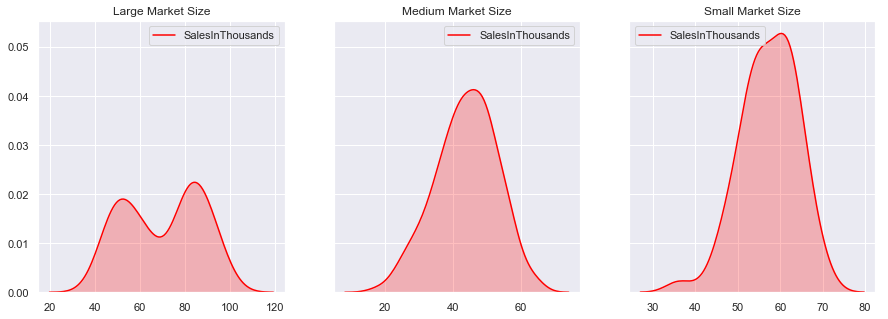

In [45]:
sns.set(color_codes=True)
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
sns.kdeplot(df[df.MarketSize == 0].SalesInThousands, shade = True, color = 'red', ax=ax[0])
sns.kdeplot(df[df.MarketSize == 1].SalesInThousands, shade = True, color = 'red', ax=ax[1])
sns.kdeplot(df[df.MarketSize == 2].SalesInThousands, shade = True, color = 'red', ax=ax[2])
ax[0].set_title("Large Market Size")
ax[1].set_title("Medium Market Size")
ax[2].set_title("Small Market Size")
plt.show()


### Changing Dependent Variable to Profit Indicator

In [46]:
profit_ = {True:1, False:0}
profit_flag = [profit_[i > 0] for i in log_df['pct_change']]
log_df['profit_flag'] = profit_flag

In [47]:
df2 = log_df.drop(['pct_change', 'sales70_flag'],axis=1).copy()
df2.head()

LocationID  AgeOfStore  SalesInThousands  MarketID_1  MarketID_2  \
0           1           4             33.73           1           0   
1           1           4             35.67           1           0   
2           1           4             29.03           1           0   
3           1           4             39.25           1           0   
4           2           5             27.81           1           0   

   MarketID_3  MarketID_4  MarketID_5  MarketID_6  MarketID_7     ...       \
0           0           0           0           0           0     ...        
1           0           0           0           0           0     ...        
2           0           0           0           0           0     ...        
3           0           0           0           0           0     ...        
4           0           0           0           0           0     ...        

   MarketSize_1  MarketSize_2  Promotion_1  Promotion_2  Promotion_3  week_1  \
0             1             0            0            0            1       1   
1             1             0            0            0            1       0   
2             1             0            0            0            1       0   
3             1             0            0            0            1       0   
4             1             0            0            1            0       1   

   week_2  week_3  week_4  profit_flag  
0       0       0       0            0  
1       1       0       0            1  
2       0       1       0            0  
3       0       0       1            1  
4       0       0       0            0  

[5 rows x 24 columns]

### Lasso for Feature Selection

In [48]:
X_ = df2.drop(['profit_flag'], axis = 1).copy()
y_ = df2.profit_flag.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 


#feature selection using Lasso
selected = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
selected.fit(x_train, y_train)

C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [49]:
selected_feat = x_train.columns[(selected.get_support())]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(selected.estimator_.coef_ == 0)))

total features: 23
selected features: 16
features with coefficients shrank to zero: 7


In [50]:
removed_feats = x_train.columns[(selected.estimator_.coef_ == 0).ravel().tolist()]
print("features removed from Lasso Regression:")
for i in removed_feats:
    print(i)

features removed from Lasso Regression:
MarketID_1
MarketID_4
MarketID_8
MarketID_10
MarketSize_1
Promotion_2
week_4


In [51]:
sel_feats = []
for i in x_train.columns:
    if(i not in removed_feats):
        sel_feats.append(i)
        
print("features selected from Lasso Regression:")
sel_feats

features selected from Lasso Regression:


['LocationID',
 'AgeOfStore',
 'SalesInThousands',
 'MarketID_2',
 'MarketID_3',
 'MarketID_5',
 'MarketID_6',
 'MarketID_7',
 'MarketID_9',
 'MarketSize_0',
 'MarketSize_2',
 'Promotion_1',
 'Promotion_3',
 'week_1',
 'week_2',
 'week_3']

In [52]:
#remove unnecessary features from training
x_train_sel = selected.transform(x_train.fillna(0))
x_test_sel = selected.transform(x_test.fillna(0))

x_train_sel.shape,x_test_sel.shape

((438, 16), (110, 16))

In [53]:
#Test Model
lr = LogisticRegression(C=1, penalty='l1')
model = lr.fit(x_train_sel, y_train)

preds = lr.predict(x_test_sel)

acc = round(sum(preds == y_test)/len(y_test),3)
print("Logistic Regression Accuracy with Profit as Dependent: ", acc)

Logistic Regression Accuracy with Profit as Dependent:  0.855


C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Notes

* because theres 2 groups in the sales data, attempt to cluster those less than 70 and those greater than 70
* Feature Engineering:
    - Create threshold vars for classification/clustering 
    - each location has 4 weeks recorded so determine the rate of change/percentage change
    - Analyze each promotion type inidivually in clusters
    - Market size is not evenly distributed. Medium is most abundant
    - Potential models... Clustering, logistic regression, mlr
    

In [54]:
df2 = pd.read_csv("Customer_Churn_Dataset.csv")
df2.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  DeviceProtection  \
0  No phone service             DSL             No  ...                No   
1                No             DSL            Yes  ...               Yes   
2                No             DSL            Yes  ...                No   
3  No phone service             DSL            Yes  ...               Yes   
4                No     Fiber optic             No  ...                No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [55]:
df2.shape

(7043, 21)

## Preprocessing: Identify Categorical and Continuous Variables

In [56]:
cols2 = df2.columns
cols2

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [57]:
df2.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [58]:
possible_categorical = [i  for i in cols2 if len(df2[i].value_counts()) < 11]
possible_cont = [i for i in cols2 if i not in possible_categorical]       

possible_cont

['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [59]:
possible_categorical

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [60]:
df2.MultipleLines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [61]:
df2.Dependents.value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

In [62]:
#repeated_customers = []
#for i in range(0,len(df2.customerID.value_counts())):
#    if df2.customerID.value_counts()[i] > 1:
#        repeated_customers.append(df2.customerID.value_counts().index[i])

#print("Number of Repeated Customers: ", len(repeated_customers))

In [63]:
cont_vars = possible_cont[1:].copy()
cat_vars = possible_categorical.copy()
cat_vars.append(possible_cont[0])

In [64]:
cont_vars

['tenure', 'MonthlyCharges', 'TotalCharges']

In [65]:
cat_vars

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'customerID']

In [66]:
df2.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  DeviceProtection  \
0  No phone service             DSL             No  ...                No   
1                No             DSL            Yes  ...               Yes   
2                No             DSL            Yes  ...                No   
3  No phone service             DSL            Yes  ...               Yes   
4                No     Fiber optic             No  ...                No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [67]:
cat_dict = {i:dict() for i in cat_vars[:-1]}
cat_dict

{'gender': {},
 'SeniorCitizen': {},
 'Partner': {},
 'Dependents': {},
 'PhoneService': {},
 'MultipleLines': {},
 'InternetService': {},
 'OnlineSecurity': {},
 'OnlineBackup': {},
 'DeviceProtection': {},
 'TechSupport': {},
 'StreamingTV': {},
 'StreamingMovies': {},
 'Contract': {},
 'PaperlessBilling': {},
 'PaymentMethod': {},
 'Churn': {}}

In [68]:
{ cat_dict[x].update([(i,j)])for x in cat_vars[:-1] for j, i in enumerate(np.unique(df2[x]))}

{None}

In [69]:
cat_dict

{'gender': {'Female': 0, 'Male': 1},
 'SeniorCitizen': {0: 0, 1: 1},
 'Partner': {'No': 0, 'Yes': 1},
 'Dependents': {'No': 0, 'Yes': 1},
 'PhoneService': {'No': 0, 'Yes': 1},
 'MultipleLines': {'No': 0, 'No phone service': 1, 'Yes': 2},
 'InternetService': {'DSL': 0, 'Fiber optic': 1, 'No': 2},
 'OnlineSecurity': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'OnlineBackup': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'DeviceProtection': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'TechSupport': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'StreamingTV': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'StreamingMovies': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
 'PaperlessBilling': {'No': 0, 'Yes': 1},
 'PaymentMethod': {'Bank transfer (automatic)': 0,
  'Credit card (automatic)': 1,
  'Electronic check': 2,
  'Mailed check': 3},
 'Churn': {'No': 0, 'Yes': 1}}

In [70]:
cat_dict.keys()

dict_keys(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'])

In [71]:
ohe_cats = np.array([np.array(df2[i].apply(lambda x: cat_dict[i][x])) for i in cat_dict.keys()])

In [72]:
ohe_cats

array([[0, 1, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [2, 3, 3, ..., 2, 3, 0],
       [0, 0, 1, ..., 0, 1, 0]], dtype=int64)

In [73]:
cat_enum = pd.DataFrame(ohe_cats.T)
cat_enum.columns = cat_dict.keys()
cat_enum.head()

gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
0       0              0        1           0             0              1   
1       1              0        0           0             1              0   
2       1              0        0           0             1              0   
3       1              0        0           0             0              1   
4       0              0        0           0             1              0   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0                0               0             2                 0   
1                0               2             0                 2   
2                0               2             2                 0   
3                0               2             0                 2   
4                1               0             0                 0   

   TechSupport  StreamingTV  StreamingMovies  Contract  PaperlessBilling  \
0            0            0                0         0                 1   
1            0            0                0         1                 0   
2            0            0                0         0                 1   
3            2            0                0         1                 0   
4            0            0                0         0                 1   

   PaymentMethod  Churn  
0              2      0  
1              3      0  
2              3      1  
3              0      0  
4              2      1

In [74]:
df2_enum = pd.concat([cat_enum, df2[cont_vars], df2['customerID']], axis =1)

In [75]:
df2_enum.head()

gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
0       0              0        1           0             0              1   
1       1              0        0           0             1              0   
2       1              0        0           0             1              0   
3       1              0        0           0             0              1   
4       0              0        0           0             1              0   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0                0               0             2                 0   
1                0               2             0                 2   
2                0               2             2                 0   
3                0               2             0                 2   
4                1               0             0                 0   

      ...      StreamingTV  StreamingMovies  Contract  PaperlessBilling  \
0     ...                0                0         0                 1   
1     ...                0                0         1                 0   
2     ...                0                0         0                 1   
3     ...                0                0         1                 0   
4     ...                0                0         0                 1   

   PaymentMethod  Churn  tenure  MonthlyCharges  TotalCharges  customerID  
0              2      0       1           29.85         29.85  7590-VHVEG  
1              3      0      34           56.95        1889.5  5575-GNVDE  
2              3      1       2           53.85        108.15  3668-QPYBK  
3              0      0      45           42.30       1840.75  7795-CFOCW  
4              2      1       2           70.70        151.65  9237-HQITU  

[5 rows x 21 columns]

In [76]:
df2_enum.shape

(7043, 21)

In [77]:
df2.shape

(7043, 21)

In [78]:
reverse_cat_dict = {i:dict() for i in cat_vars[:-1]}

In [79]:
{reverse_cat_dict[i].update(map(reversed, cat_dict[i].items())) for i in cat_dict.keys()}

{None}

In [80]:
reverse_cat_dict

{'gender': {0: 'Female', 1: 'Male'},
 'SeniorCitizen': {0: 0, 1: 1},
 'Partner': {0: 'No', 1: 'Yes'},
 'Dependents': {0: 'No', 1: 'Yes'},
 'PhoneService': {0: 'No', 1: 'Yes'},
 'MultipleLines': {0: 'No', 1: 'No phone service', 2: 'Yes'},
 'InternetService': {0: 'DSL', 1: 'Fiber optic', 2: 'No'},
 'OnlineSecurity': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'OnlineBackup': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'DeviceProtection': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'TechSupport': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'StreamingTV': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'StreamingMovies': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'Contract': {0: 'Month-to-month', 1: 'One year', 2: 'Two year'},
 'PaperlessBilling': {0: 'No', 1: 'Yes'},
 'PaymentMethod': {0: 'Bank transfer (automatic)',
  1: 'Credit card (automatic)',
  2: 'Electronic check',
  3: 'Mailed check'},
 'Churn': {0: 'No', 1: 'Yes'}}

## Logistic Regression Model for Determining Churn

#### One Hot Encode Categorical Variables

In [81]:
cat_cols = [i for i in cat_dict.keys() if i != 'Churn']

ohe_df2 = pd.get_dummies(data=df2, columns = cat_cols)
ohe_df2.Churn = df2_enum.Churn

In [82]:
ohe_df2.head()

customerID  tenure  MonthlyCharges TotalCharges  Churn  gender_Female  \
0  7590-VHVEG       1           29.85        29.85      0              1   
1  5575-GNVDE      34           56.95       1889.5      0              0   
2  3668-QPYBK       2           53.85       108.15      1              0   
3  7795-CFOCW      45           42.30      1840.75      0              0   
4  9237-HQITU       2           70.70       151.65      1              1   

   gender_Male  SeniorCitizen_0  SeniorCitizen_1  Partner_No  \
0            0                1                0           0   
1            1                1                0           1   
2            1                1                0           1   
3            1                1                0           1   
4            0                1                0           1   

              ...              StreamingMovies_Yes  Contract_Month-to-month  \
0             ...                                0                        1   
1             ...                                0                        0   
2             ...                                0                        1   
3             ...                                0                        0   
4             ...                                0                        1   

   Contract_One year  Contract_Two year  PaperlessBilling_No  \
0                  0                  0                    0   
1                  1                  0                    1   
2                  0                  0                    0   
3                  1                  0                    1   
4                  0                  0                    0   

   PaperlessBilling_Yes  PaymentMethod_Bank transfer (automatic)  \
0                     1                                        0   
1                     0                                        0   
2                     1                                        0   
3                     0                                        1   
4                     1                                        0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 48 columns]

#### Lasso Regression for Feature Selection

In [83]:
ohe_df2.TotalCharges = pd.to_numeric(ohe_df2.TotalCharges,errors='coerce')

In [84]:
ohe_df2.dropna(inplace=True)

In [85]:
X_ = ohe_df2.drop(['Churn', 'customerID'], axis = 1).copy()
y_ = ohe_df2.Churn.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 


#feature selection using Lasso
selected = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
selected.fit(x_train, y_train)

C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [86]:
selected_feat = x_train.columns[(selected.get_support())]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(selected.estimator_.coef_ == 0)))

total features: 46
selected features: 30
features with coefficients shrank to zero: 16


In [87]:
removed_feats = x_train.columns[(selected.estimator_.coef_ == 0).ravel().tolist()]
print("features removed from Lasso Regression:")
for i in removed_feats:
    print(i)

features removed from Lasso Regression:
gender_Female
SeniorCitizen_1
Partner_Yes
Dependents_No
PhoneService_No
MultipleLines_No phone service
InternetService_No
OnlineSecurity_No internet service
OnlineBackup_No internet service
DeviceProtection_Yes
TechSupport_No internet service
TechSupport_Yes
StreamingTV_No internet service
StreamingMovies_No internet service
PaperlessBilling_Yes
PaymentMethod_Bank transfer (automatic)


In [88]:
sel_feats = []
for i in x_train.columns:
    if(i not in removed_feats):
        sel_feats.append(i)
        
print("features selected from Lasso Regression:")
sel_feats

features selected from Lasso Regression:


['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Male',
 'SeniorCitizen_0',
 'Partner_No',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'OnlineSecurity_No',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'TechSupport_No',
 'StreamingTV_No',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_No',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [89]:
#remove unnecessary features from training
x_train_sel = selected.transform(x_train.fillna(0))
x_test_sel = selected.transform(x_test.fillna(0))

x_train_sel.shape,x_test_sel.shape

((5625, 30), (1407, 30))

In [90]:
#Test Model
lr = LogisticRegression(C=1, penalty='l1')
model = lr.fit(x_train_sel, y_train)

preds = lr.predict(x_test_sel)

churn_acc = round(sum(preds == y_test)/len(y_test),3)
print("Logistic Regression Accuracy with Churn as Dependent: ", churn_acc)

C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy with Churn as Dependent:  0.788
